<a href="https://colab.research.google.com/github/Shubodh/learn_mol/blob/vgae%2Fdimenet%2Fgatconv_shub_0soutput_issue/dimenet_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/zotko/xyz2graph.git plotly networkx torch_geometric rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/zotko/xyz2graph.git to /tmp/pip-req-build-gjty8nt4
  Running command git clone -q https://github.com/zotko/xyz2graph.git /tmp/pip-req-build-gjty8nt4
     |████████████████████████████████| 564 kB 8.0 MB/s 
     |████████████████████████████████| 29.3 MB 1.5 MB/s 
     |████████████████████████████████| 280 kB 73.2 MB/s 
  Created wheel for xyz2graph: filename=xyz2graph-2.0.0-py3-none-any.whl size=6087 sha256=f7d6e48ae3df04f0dd9aa22a8cac3c2837a73a0984e597a3ae12bc44a901b804
  Stored in directory: /tmp/pip-ephem-wheel-cache-n2ylibcc/wheels/2c/4f/6c/35eec158016e29fa89f15263a8a04b4980e34fdaf615df91d8
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=f0dd6bbc4a75c8fbe8a2fa7a34c05d74b90dbf60dc877ac7e9f4056144c55ac9
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55

In [ ]:
import torch
print(torch.__version__)
!pip install torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html

1.13.0+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 9.4 MB 8.5 MB/s 
     |████████████████████████████████| 4.5 MB 56.8 MB/s 
     |████████████████████████████████| 3.2 MB 47.9 MB/s 


In [ ]:
from xyz2graph import MolGraph, to_networkx_graph, to_plotly_figure
from plotly.offline import init_notebook_mode, iplot
import networkx as nx
import numpy as np
import torch
from torch_geometric.utils.convert import from_networkx
from torch_geometric.utils import negative_sampling
import re
from itertools import combinations
from math import sqrt
from torch_geometric.nn import DimeNet
from rdkit import Chem
import random
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch import Tensor
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import train_test_split_edges
from sklearn.preprocessing import OneHotEncoder
from torch_geometric.datasets import QM9
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
from rdkit.Chem import Draw
import pandas as pd
from torch_scatter import scatter
import torch_geometric.datasets as data

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dimenet

In [ ]:
import os
import os.path as osp
from math import pi as PI
from math import sqrt
from typing import Callable, Optional, Tuple, Union

import numpy as np
import torch
from torch import Tensor
from torch.nn import Embedding, Linear
from torch_scatter import scatter
from torch_sparse import SparseTensor

from torch_geometric.data import Dataset, download_url
from torch_geometric.data.makedirs import makedirs
from torch_geometric.nn import radius_graph
from torch_geometric.nn.inits import glorot_orthogonal
from torch_geometric.nn.resolver import activation_resolver
from torch_geometric.typing import OptTensor

qm9_target_dict = {
    0: 'mu',
    1: 'alpha',
    2: 'homo',
    3: 'lumo',
    5: 'r2',
    6: 'zpve',
    7: 'U0',
    8: 'U',
    9: 'H',
    10: 'G',
    11: 'Cv',
}


class Envelope(torch.nn.Module):
    def __init__(self, exponent: int):
        super().__init__()
        self.p = exponent + 1
        self.a = -(self.p + 1) * (self.p + 2) / 2
        self.b = self.p * (self.p + 2)
        self.c = -self.p * (self.p + 1) / 2

    def forward(self, x: Tensor) -> Tensor:
        p, a, b, c = self.p, self.a, self.b, self.c
        x_pow_p0 = x.pow(p - 1)
        x_pow_p1 = x_pow_p0 * x
        x_pow_p2 = x_pow_p1 * x
        return (1. / x + a * x_pow_p0 + b * x_pow_p1 +
                c * x_pow_p2) * (x < 1.0).to(x.dtype)


class BesselBasisLayer(torch.nn.Module):
    def __init__(self, num_radial: int, cutoff: float = 5.0,
                 envelope_exponent: int = 5):
        super().__init__()
        self.cutoff = cutoff
        self.envelope = Envelope(envelope_exponent)

        self.freq = torch.nn.Parameter(torch.Tensor(num_radial))

        self.reset_parameters()

    def reset_parameters(self):
        with torch.no_grad():
            torch.arange(1, self.freq.numel() + 1, out=self.freq).mul_(PI)
        self.freq.requires_grad_()

    def forward(self, dist: Tensor) -> Tensor:
        dist = (dist.unsqueeze(-1) / self.cutoff)
        return self.envelope(dist) * (self.freq * dist).sin()


class SphericalBasisLayer(torch.nn.Module):
    def __init__(self, num_spherical: int, num_radial: int,
                 cutoff: float = 5.0, envelope_exponent: int = 5):
        super().__init__()
        import sympy as sym

        from torch_geometric.nn.models.dimenet_utils import (
            bessel_basis,
            real_sph_harm,
        )

        assert num_radial <= 64
        self.num_spherical = num_spherical
        self.num_radial = num_radial
        self.cutoff = cutoff
        self.envelope = Envelope(envelope_exponent)

        bessel_forms = bessel_basis(num_spherical, num_radial)
        sph_harm_forms = real_sph_harm(num_spherical)
        self.sph_funcs = []
        self.bessel_funcs = []

        x, theta = sym.symbols('x theta')
        modules = {'sin': torch.sin, 'cos': torch.cos}
        for i in range(num_spherical):
            if i == 0:
                sph1 = sym.lambdify([theta], sph_harm_forms[i][0], modules)(0)
                self.sph_funcs.append(lambda x: torch.zeros_like(x) + sph1)
            else:
                sph = sym.lambdify([theta], sph_harm_forms[i][0], modules)
                self.sph_funcs.append(sph)
            for j in range(num_radial):
                bessel = sym.lambdify([x], bessel_forms[i][j], modules)
                self.bessel_funcs.append(bessel)

    def forward(self, dist: Tensor, angle: Tensor, idx_kj: Tensor) -> Tensor:
        dist = dist / self.cutoff
        rbf = torch.stack([f(dist) for f in self.bessel_funcs], dim=1)
        rbf = self.envelope(dist).unsqueeze(-1) * rbf

        cbf = torch.stack([f(angle) for f in self.sph_funcs], dim=1)

        n, k = self.num_spherical, self.num_radial
        out = (rbf[idx_kj].view(-1, n, k) * cbf.view(-1, n, 1)).view(-1, n * k)
        return out


class EmbeddingBlock(torch.nn.Module):
    def __init__(self, num_radial: int, hidden_channels: int, act: Callable):
        super().__init__()
        self.act = act

        self.emb = Embedding(95, hidden_channels)
        self.lin_rbf = Linear(num_radial, hidden_channels)
        self.lin = Linear(3 * hidden_channels, hidden_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.emb.weight.data.uniform_(-sqrt(3), sqrt(3))
        self.lin_rbf.reset_parameters()
        self.lin.reset_parameters()

    def forward(self, x: Tensor, rbf: Tensor, i: Tensor, j: Tensor) -> Tensor:
        x = self.emb(x)
        rbf = self.act(self.lin_rbf(rbf))
        return self.act(self.lin(torch.cat([x[i], x[j], rbf], dim=-1)))


class ResidualLayer(torch.nn.Module):
    def __init__(self, hidden_channels: int, act: Callable):
        super().__init__()
        self.act = act
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)

        self.reset_parameters()

    def reset_parameters(self):
        glorot_orthogonal(self.lin1.weight, scale=2.0)
        self.lin1.bias.data.fill_(0)
        glorot_orthogonal(self.lin2.weight, scale=2.0)
        self.lin2.bias.data.fill_(0)

    def forward(self, x: Tensor) -> Tensor:
        return x + self.act(self.lin2(self.act(self.lin1(x))))


class InteractionBlock(torch.nn.Module):
    def __init__(self, hidden_channels: int, num_bilinear: int,
                 num_spherical: int, num_radial: int, num_before_skip: int,
                 num_after_skip: int, act: Callable):
        super().__init__()
        self.act = act

        self.lin_rbf = Linear(num_radial, hidden_channels, bias=False)
        self.lin_sbf = Linear(num_spherical * num_radial, num_bilinear,
                              bias=False)

        # Dense transformations of input messages.
        self.lin_kj = Linear(hidden_channels, hidden_channels)
        self.lin_ji = Linear(hidden_channels, hidden_channels)

        self.W = torch.nn.Parameter(
            torch.Tensor(hidden_channels, num_bilinear, hidden_channels))

        self.layers_before_skip = torch.nn.ModuleList([
            ResidualLayer(hidden_channels, act) for _ in range(num_before_skip)
        ])
        self.lin = Linear(hidden_channels, hidden_channels)
        self.layers_after_skip = torch.nn.ModuleList([
            ResidualLayer(hidden_channels, act) for _ in range(num_after_skip)
        ])

        self.reset_parameters()

    def reset_parameters(self):
        glorot_orthogonal(self.lin_rbf.weight, scale=2.0)
        glorot_orthogonal(self.lin_sbf.weight, scale=2.0)
        glorot_orthogonal(self.lin_kj.weight, scale=2.0)
        self.lin_kj.bias.data.fill_(0)
        glorot_orthogonal(self.lin_ji.weight, scale=2.0)
        self.lin_ji.bias.data.fill_(0)
        self.W.data.normal_(mean=0, std=2 / self.W.size(0))
        for res_layer in self.layers_before_skip:
            res_layer.reset_parameters()
        glorot_orthogonal(self.lin.weight, scale=2.0)
        self.lin.bias.data.fill_(0)
        for res_layer in self.layers_after_skip:
            res_layer.reset_parameters()

    def forward(self, x: Tensor, rbf: Tensor, sbf: Tensor, idx_kj: Tensor,
                idx_ji: Tensor) -> Tensor:
        rbf = self.lin_rbf(rbf)
        sbf = self.lin_sbf(sbf)

        x_ji = self.act(self.lin_ji(x))
        x_kj = self.act(self.lin_kj(x))
        x_kj = x_kj * rbf
        x_kj = torch.einsum('wj,wl,ijl->wi', sbf, x_kj[idx_kj], self.W)
        x_kj = scatter(x_kj, idx_ji, dim=0, dim_size=x.size(0))

        h = x_ji + x_kj
        for layer in self.layers_before_skip:
            h = layer(h)
        h = self.act(self.lin(h)) + x
        for layer in self.layers_after_skip:
            h = layer(h)

        return h



class OutputBlock(torch.nn.Module):
    def __init__(self, num_radial: int, hidden_channels: int,
                 out_channels: int, num_layers: int, act: Callable):
        super().__init__()
        self.act = act

        self.lin_rbf = Linear(num_radial, hidden_channels, bias=False)
        self.lins = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.lins.append(Linear(hidden_channels, hidden_channels))
        self.lin = Linear(hidden_channels, out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        glorot_orthogonal(self.lin_rbf.weight, scale=2.0)
        for lin in self.lins:
            glorot_orthogonal(lin.weight, scale=2.0)
            lin.bias.data.fill_(0)
        self.lin.weight.data.fill_(0)

    def forward(self, x: Tensor, rbf: Tensor, i: Tensor,
                num_nodes: Optional[int] = None, debug=False) -> Tensor:
        if debug:
            print('inside output block')
        x = self.lin_rbf(rbf) * x
        if debug: print('after lin_rbf', x)
        x = scatter(x, i, dim=0, dim_size=num_nodes)
        for lin in self.lins:
            x = self.act(lin(x))
        if debug: print('after lins', x)
        x = self.lin(x)
        if debug: print('final output', x)
        return x

class DimeNet(torch.nn.Module):
    r"""The directional message passing neural network (DimeNet) from the
    `"Directional Message Passing for Molecular Graphs"
    <https://arxiv.org/abs/2003.03123>`_ paper.
    DimeNet transforms messages based on the angle between them in a
    rotation-equivariant fashion.

    .. note::

        For an example of using a pretrained DimeNet variant, see
        `examples/qm9_pretrained_dimenet.py
        <https://github.com/pyg-team/pytorch_geometric/blob/master/examples/
        qm9_pretrained_dimenet.py>`_.

    Args:
        hidden_channels (int): Hidden embedding size.
        out_channels (int): Size of each output sample.
        num_blocks (int): Number of building blocks.
        num_bilinear (int): Size of the bilinear layer tensor.
        num_spherical (int): Number of spherical harmonics.
        num_radial (int): Number of radial basis functions.
        cutoff (float, optional): Cutoff distance for interatomic
            interactions. (default: :obj:`5.0`)
        max_num_neighbors (int, optional): The maximum number of neighbors to
            collect for each node within the :attr:`cutoff` distance.
            (default: :obj:`32`)
        envelope_exponent (int, optional): Shape of the smooth cutoff.
            (default: :obj:`5`)
        num_before_skip (int, optional): Number of residual layers in the
            interaction blocks before the skip connection. (default: :obj:`1`)
        num_after_skip (int, optional): Number of residual layers in the
            interaction blocks after the skip connection. (default: :obj:`2`)
        num_output_layers (int, optional): Number of linear layers for the
            output blocks. (default: :obj:`3`)
        act (str or Callable, optional): The activation function.
            (default: :obj:`"swish"`)
    """

    url = ('https://github.com/klicperajo/dimenet/raw/master/pretrained/'
           'dimenet')

    def __init__(
        self,
        hidden_channels: int,
        out_channels: int,
        num_blocks: int,
        num_bilinear: int,
        num_spherical: int,
        num_radial,
        cutoff: float = 5.0,
        max_num_neighbors: int = 32,
        envelope_exponent: int = 5,
        num_before_skip: int = 1,
        num_after_skip: int = 2,
        num_output_layers: int = 3,
        act: Union[str, Callable] = 'swish',
    ):
        super().__init__()

        if num_spherical < 2:
            raise ValueError("num_spherical should be greater than 1")

        act = activation_resolver(act)

        self.cutoff = cutoff
        self.max_num_neighbors = max_num_neighbors
        self.num_blocks = num_blocks

        self.rbf = BesselBasisLayer(num_radial, cutoff, envelope_exponent)
        self.sbf = SphericalBasisLayer(num_spherical, num_radial, cutoff,
                                       envelope_exponent)

        self.emb = EmbeddingBlock(num_radial, hidden_channels, act)

        self.output_blocks = torch.nn.ModuleList([
            OutputBlock(num_radial, hidden_channels, out_channels,
                        num_output_layers, act) for _ in range(num_blocks + 1)
        ])

        self.interaction_blocks = torch.nn.ModuleList([
            InteractionBlock(hidden_channels, num_bilinear, num_spherical,
                             num_radial, num_before_skip, num_after_skip, act)
            for _ in range(num_blocks)
        ])

        # self.reset_parameters()

    def reset_parameters(self):
        self.rbf.reset_parameters()
        self.emb.reset_parameters()
        for out in self.output_blocks:
            out.reset_parameters()
        for interaction in self.interaction_blocks:
            interaction.reset_parameters()


    def triplets(
        self,
        edge_index: Tensor,
        num_nodes: int,
    ) -> Tuple[Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor]:
        row, col = edge_index  # j->i

        value = torch.arange(row.size(0), device=row.device)
        adj_t = SparseTensor(row=col, col=row, value=value,
                             sparse_sizes=(num_nodes, num_nodes))
        adj_t_row = adj_t[row]
        num_triplets = adj_t_row.set_value(None).sum(dim=1).to(torch.long)

        # Node indices (k->j->i) for triplets.
        idx_i = col.repeat_interleave(num_triplets)
        idx_j = row.repeat_interleave(num_triplets)
        idx_k = adj_t_row.storage.col()
        mask = idx_i != idx_k  # Remove i == k triplets.
        idx_i, idx_j, idx_k = idx_i[mask], idx_j[mask], idx_k[mask]

        # Edge indices (k-j, j->i) for triplets.
        idx_kj = adj_t_row.storage.value()[mask]
        idx_ji = adj_t_row.storage.row()[mask]

        return col, row, idx_i, idx_j, idx_k, idx_kj, idx_ji

    def forward(
        self,
        z: Tensor,
        pos: Tensor,
        batch: OptTensor = None,
        debug = False
    ) -> Tensor:
        """"""
        edge_index = radius_graph(pos, r=self.cutoff, batch=batch,
                                  max_num_neighbors=self.max_num_neighbors)
        if debug: print(edge_index)
        i, j, idx_i, idx_j, idx_k, idx_kj, idx_ji = self.triplets(
            edge_index, num_nodes=z.size(0))

        # Calculate distances.
        dist = (pos[i] - pos[j]).pow(2).sum(dim=-1).sqrt()

        # Calculate angles.
        pos_i = pos[idx_i]
        pos_ji, pos_ki = pos[idx_j] - pos_i, pos[idx_k] - pos_i
        a = (pos_ji * pos_ki).sum(dim=-1)
        b = torch.cross(pos_ji, pos_ki).norm(dim=-1)
        angle = torch.atan2(b, a)

        rbf = self.rbf(dist)
        sbf = self.sbf(dist, angle, idx_kj)
        if debug: 
            print("RBF: \n", rbf)
            print("SBF: \n", sbf)
        # Embedding block.
        x = self.emb(z, rbf, i, j)
        P = self.output_blocks[0](x, rbf, i, num_nodes=pos.size(0), debug=debug)
        if debug:
            print("output after embedding layer")
            print(P)
        # Interaction blocks.
        for interaction_block, output_block in zip(self.interaction_blocks,
                                                   self.output_blocks[1:]):
            x = interaction_block(x, rbf, sbf, idx_kj, idx_ji)
            P = P + output_block(x, rbf, i, debug=debug)
            if debug:
                print("output after interaction layer")
                print(P)
                print("state after interaction layer")
                print(x)
        # return P.sum(dim=0) if batch is None else scatter(P, batch, dim=0)
        return P

class DimeNet_OG(torch.nn.Module):
    r"""The directional message passing neural network (DimeNet) from the
    `"Directional Message Passing for Molecular Graphs"
    <https://arxiv.org/abs/2003.03123>`_ paper.
    DimeNet transforms messages based on the angle between them in a
    rotation-equivariant fashion.

    .. note::

        For an example of using a pretrained DimeNet variant, see
        `examples/qm9_pretrained_dimenet.py
        <https://github.com/pyg-team/pytorch_geometric/blob/master/examples/
        qm9_pretrained_dimenet.py>`_.

    Args:
        hidden_channels (int): Hidden embedding size.
        out_channels (int): Size of each output sample.
        num_blocks (int): Number of building blocks.
        num_bilinear (int): Size of the bilinear layer tensor.
        num_spherical (int): Number of spherical harmonics.
        num_radial (int): Number of radial basis functions.
        cutoff (float, optional): Cutoff distance for interatomic
            interactions. (default: :obj:`5.0`)
        max_num_neighbors (int, optional): The maximum number of neighbors to
            collect for each node within the :attr:`cutoff` distance.
            (default: :obj:`32`)
        envelope_exponent (int, optional): Shape of the smooth cutoff.
            (default: :obj:`5`)
        num_before_skip (int, optional): Number of residual layers in the
            interaction blocks before the skip connection. (default: :obj:`1`)
        num_after_skip (int, optional): Number of residual layers in the
            interaction blocks after the skip connection. (default: :obj:`2`)
        num_output_layers (int, optional): Number of linear layers for the
            output blocks. (default: :obj:`3`)
        act (str or Callable, optional): The activation function.
            (default: :obj:`"swish"`)
    """

    url = ('https://github.com/klicperajo/dimenet/raw/master/pretrained/'
           'dimenet')

    def __init__(
        self,
        hidden_channels: int,
        out_channels: int,
        num_blocks: int,
        num_bilinear: int,
        num_spherical: int,
        num_radial,
        cutoff: float = 5.0,
        max_num_neighbors: int = 32,
        envelope_exponent: int = 5,
        num_before_skip: int = 1,
        num_after_skip: int = 2,
        num_output_layers: int = 3,
        act: Union[str, Callable] = 'swish',
    ):
        super().__init__()

        if num_spherical < 2:
            raise ValueError("num_spherical should be greater than 1")

        act = activation_resolver(act)

        self.cutoff = cutoff
        self.max_num_neighbors = max_num_neighbors
        self.num_blocks = num_blocks

        self.rbf = BesselBasisLayer(num_radial, cutoff, envelope_exponent)
        self.sbf = SphericalBasisLayer(num_spherical, num_radial, cutoff,
                                       envelope_exponent)

        self.emb = EmbeddingBlock(num_radial, hidden_channels, act)

        self.output_blocks = torch.nn.ModuleList([
            OutputBlock(num_radial, hidden_channels, out_channels,
                        num_output_layers, act) for _ in range(num_blocks + 1)
        ])

        self.interaction_blocks = torch.nn.ModuleList([
            InteractionBlock(hidden_channels, num_bilinear, num_spherical,
                             num_radial, num_before_skip, num_after_skip, act)
            for _ in range(num_blocks)
        ])

        self.reset_parameters()

    def reset_parameters(self):
        self.rbf.reset_parameters()
        self.emb.reset_parameters()
        for out in self.output_blocks:
            out.reset_parameters()
        for interaction in self.interaction_blocks:
            interaction.reset_parameters()


    def triplets(
        self,
        edge_index: Tensor,
        num_nodes: int,
    ) -> Tuple[Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor]:
        row, col = edge_index  # j->i

        value = torch.arange(row.size(0), device=row.device)
        adj_t = SparseTensor(row=col, col=row, value=value,
                             sparse_sizes=(num_nodes, num_nodes))
        adj_t_row = adj_t[row]
        num_triplets = adj_t_row.set_value(None).sum(dim=1).to(torch.long)

        # Node indices (k->j->i) for triplets.
        idx_i = col.repeat_interleave(num_triplets)
        idx_j = row.repeat_interleave(num_triplets)
        idx_k = adj_t_row.storage.col()
        mask = idx_i != idx_k  # Remove i == k triplets.
        idx_i, idx_j, idx_k = idx_i[mask], idx_j[mask], idx_k[mask]

        # Edge indices (k-j, j->i) for triplets.
        idx_kj = adj_t_row.storage.value()[mask]
        idx_ji = adj_t_row.storage.row()[mask]

        return col, row, idx_i, idx_j, idx_k, idx_kj, idx_ji

    def forward(
        self,
        z: Tensor,
        pos: Tensor,
        batch: OptTensor = None,
        debug= False
    ) -> Tensor:
        """"""
        edge_index = radius_graph(pos, r=self.cutoff, batch=batch,
                                  max_num_neighbors=self.max_num_neighbors)

        i, j, idx_i, idx_j, idx_k, idx_kj, idx_ji = self.triplets(
            edge_index, num_nodes=z.size(0))

        # Calculate distances.
        dist = (pos[i] - pos[j]).pow(2).sum(dim=-1).sqrt()

        # Calculate angles.
        pos_i = pos[idx_i]
        pos_ji, pos_ki = pos[idx_j] - pos_i, pos[idx_k] - pos_i
        a = (pos_ji * pos_ki).sum(dim=-1)
        b = torch.cross(pos_ji, pos_ki).norm(dim=-1)
        angle = torch.atan2(b, a)

        rbf = self.rbf(dist)
        sbf = self.sbf(dist, angle, idx_kj)

        # Embedding block.
        x = self.emb(z, rbf, i, j)
        P = self.output_blocks[0](x, rbf, i, num_nodes=pos.size(0), debug=debug)
        if debug:  
            print("output after embedding layer")
            print(P)
        # Interaction blocks.
        for interaction_block, output_block in zip(self.interaction_blocks,
                                                   self.output_blocks[1:]):
            x = interaction_block(x, rbf, sbf, idx_kj, idx_ji)
            P = P + output_block(x, rbf, i, debug=debug)
            if debug:
                print("output after interaction layer")
                print(P)
                print("state after interaction layer")
                print(x)
        P = P.sum(dim=0) if batch is None else scatter(P, batch, dim=0)
        return P
        # return P.sum(dim=0) if batch is None else scatter(P, batch, dim=0)


# Dimenet as a layer

In [ ]:
class DimeNetBasic(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim=1, heads=1,num_layers=1):
        super(DimeNetBasic, self).__init__()
        self.conv1 = []
        self.conv1.append(DimeNet(
            hidden_channels=64,
            out_channels=hidden_channels,
            num_blocks=4,
            num_bilinear=8,
            num_spherical=7,
            num_radial=6,
            cutoff=5.0,
            envelope_exponent=5,
            num_before_skip=1,
            num_after_skip=2,
            num_output_layers=3,
        ))
        self.conv1 = torch.nn.ModuleList(self.conv1)
        # self.conv_mu = GATConv(hidden_channels, out_channels)
        # self.conv_logstd = GATConv(hidden_channels, out_channels)

    def forward(self, x, pos, edge_index, batch, debug=False):
        # print('Input:', x.shape)
        for conv in self.conv1:
            x = conv(x, pos, batch, debug).relu()
        if debug: print('Post dimenet:', x)
        x = x.sum(dim=0) if batch is None else scatter(x, batch, dim=0)
        if debug: print('Post summation:', x)
        return x

## Parameters and the model

In [ ]:
data_list_raw = data.QM9('./data/QM9')
N = 100
data_list = [g for g in data_list_raw[:N] if g.x.shape[0] < 20]
# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model and datasets to the device
batch_size = 32
lr = 0.001
num_layers = 1
out_channels = 2
num_features = data_list[0].x.shape[1]
epochs = 20
edge_dim = data_list[0].edge_attr.shape[1]
heads = 1
hidden_channels = 1
print(f'Node features: {num_features}')
print(f'Edge features: {edge_dim}')
split = [0.8, 0.2]
N_train = int(N * split[0])
train_data = data_list[:N_train]
test_data = data_list[N_train:]
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

Node features: 11
Edge features: 4


In [ ]:
model_config = {
    "in_channels": num_features,
    "hidden_channels": hidden_channels,
    "out_channels": out_channels,
    "num_layers": num_layers,
    "edge_dim": edge_dim,
    "heads": heads
    }
# model
model = DimeNetBasic(**model_config).to(device)
model_og = DimeNet_OG(
            hidden_channels=64,
            out_channels=hidden_channels,
            num_blocks=4,
            num_bilinear=8,
            num_spherical=7,
            num_radial=6,
            cutoff=5.0,
            envelope_exponent=5,
            num_before_skip=1,
            num_after_skip=2,
            num_output_layers=3,
        ).to(device)

## Results

In [ ]:
print('before training')
z = []
for g in train_loader:
    g = g.to(device)
    z.append(model(g.z, g.pos, g.edge_index, g.batch).detach().cpu().numpy())
z = np.vstack(z)
print(z.shape)
cnt = 0
for idx in range(z.shape[0]):
    if np.any(z[idx] != 0): cnt+=1
print(f'number of non-zero embeddings: {cnt}')

before training
tensor([[  1,   2,   3,  ..., 226, 227, 228],
        [  0,   0,   0,  ..., 229, 229, 229]], device='cuda:0')
Post_dimenet: torch.Size([230, 1])
tensor([[  1,   2,   3,  ..., 327, 329, 330],
        [  0,   0,   0,  ..., 331, 331, 331]], device='cuda:0')
Post_dimenet: torch.Size([332, 1])
tensor([[  1,   2,   3,  ..., 189, 190, 191],
        [  0,   0,   0,  ..., 192, 192, 192]], device='cuda:0')
Post_dimenet: torch.Size([193, 1])
(80, 1)
number of non-zero embeddings: 0


In [ ]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_loss = []
# Training loop
for epoch in range(100):
    # Loop over the training dataset
    for graph in train_loader:
        # Extract the data and labels
        graph = graph.to(device)
        x, pos, edge_index, y, batch = graph.z, graph.pos, graph.edge_index, graph.y[:, 0], graph.batch

        # Reset the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(x, pos, edge_index, batch)
        loss = loss_fn(output, y)
        train_loss.append(loss.item())
        print(f'epoch: {epoch} loss: {loss.item()}')
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

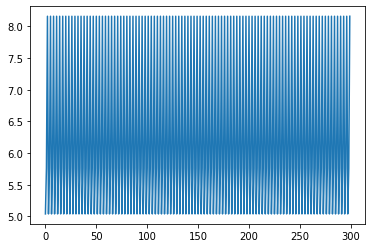

In [ ]:
plt.plot(train_loss)

In [ ]:
print('after training')
z = []
for g in train_loader:
    g = g.to(device)
    z.append(model(g.z, g.pos, g.edge_index, g.batch).detach().cpu().numpy())
z = np.vstack(z)
print(z.shape)
cnt = 0
for idx in range(z.shape[0]):
    if np.any(z[idx] != 0): cnt+=1
print(f'number of non-zero embeddings: {cnt}')

after training
(80, 1)
number of non-zero embeddings: 0


In [ ]:
g = data_list[0].to(device)
model(g.z, g.pos, g.edge_index, batch=None, debug=True)

tensor([[1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3],
        [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]],
       device='cuda:0')
RBF: 
 tensor([[ 2.8950,  4.4800,  4.0377,  1.7682, -1.3014, -3.7821],
        [ 2.8950,  4.4800,  4.0375,  1.7679, -1.3017, -3.7823],
        [ 2.8951,  4.4801,  4.0379,  1.7685, -1.3011, -3.7820],
        [ 2.8950,  4.4800,  4.0376,  1.7680, -1.3016, -3.7822],
        [ 2.8950,  4.4800,  4.0377,  1.7682, -1.3014, -3.7821],
        [ 2.4540,  2.1368, -0.5934, -2.6535, -1.7171,  1.1584],
        [ 2.4540,  2.1368, -0.5935, -2.6535, -1.7170,  1.1585],
        [ 2.4540,  2.1368, -0.5935, -2.6535, -1.7170,  1.1585],
        [ 2.8950,  4.4800,  4.0375,  1.7679, -1.3017, -3.7823],
        [ 2.4540,  2.1368, -0.5934, -2.6535, -1.7171,  1.1584],
        [ 2.4540,  2.1368, -0.5935, -2.6535, -1.7170,  1.1585],
        [ 2.4540,  2.1368, -0.5935, -2.6535, -1.7170,  1.1585],
        [ 2.8951,  4.4801,  4.0379,  1.7685, -1.3011, -3.782

tensor([0.], device='cuda:0', grad_fn=<SumBackward1>)

# Dimenet as a model

## parameters and model

In [ ]:
data_list_raw = data.QM9('./data/QM9')
N = 100
data_list = [g for g in data_list_raw[:N] if g.x.shape[0] < 20]
# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model and datasets to the device
batch_size = 32
lr = 0.001
num_layers = 1
out_channels = 2
num_features = data_list[0].x.shape[1]
epochs = 20
edge_dim = data_list[0].edge_attr.shape[1]
heads = 1
hidden_channels = 1
print(f'Node features: {num_features}')
print(f'Edge features: {edge_dim}')
split = [0.8, 0.2]
N_train = int(N * split[0])
train_data = data_list[:N_train]
test_data = data_list[N_train:]
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
model_config = {
    "in_channels": num_features,
    "hidden_channels": hidden_channels,
    "out_channels": out_channels,
    "num_layers": num_layers,
    "edge_dim": edge_dim,
    "heads": heads
    }
# model
model = DimeNet_OG(
            hidden_channels=64,
            out_channels=hidden_channels,
            num_blocks=4,
            num_bilinear=8,
            num_spherical=7,
            num_radial=6,
            cutoff=5.0,
            envelope_exponent=5,
            num_before_skip=1,
            num_after_skip=2,
            num_output_layers=3,
        ).to(device)

Node features: 11
Edge features: 4


## Results

In [ ]:
print('before training')
z = []
for g in train_loader:
    g = g.to(device)
    z.append(model_og(g.z, g.pos, g.batch).detach().cpu().numpy())
z = np.vstack(z)
print(z.shape)
cnt = 0
for idx in range(z.shape[0]):
    if np.any(z[idx] != 0): cnt+=1
print(f'number of non-zero embeddings: {cnt}')

before training
tensor([[  1,   2,   3,  ..., 226, 227, 228],
        [  0,   0,   0,  ..., 229, 229, 229]], device='cuda:0')
tensor([[  1,   2,   3,  ..., 327, 329, 330],
        [  0,   0,   0,  ..., 331, 331, 331]], device='cuda:0')
tensor([[  1,   2,   3,  ..., 189, 190, 191],
        [  0,   0,   0,  ..., 192, 192, 192]], device='cuda:0')
(755, 1)
number of non-zero embeddings: 0


In [ ]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_loss = []
# Training loop
for epoch in range(100):
    # Loop over the training dataset
    for graph in train_loader:
        # Extract the data and labels
        graph = graph.to(device)
        x, pos, edge_index, y, batch = graph.z, graph.pos, graph.edge_index, graph.y[:, 0], graph.batch

        # Reset the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(x, pos, batch)
        loss = loss_fn(output, y)
        train_loss.append(loss.item())
        print(f'epoch: {epoch} loss: {loss.item()}')
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

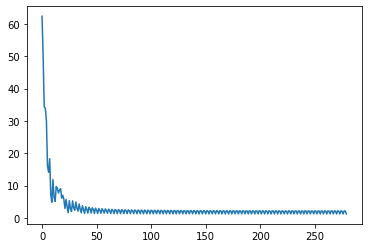

In [ ]:
plt.plot(train_loss[20:])

In [ ]:
print('after training')
z = []
for g in train_loader:
    g = g.to(device)
    z.append(model(g.z, g.pos, g.batch).detach().cpu().numpy())
z = np.vstack(z)
print(z.shape)
cnt = 0
for idx in range(z.shape[0]):
    if np.any(z[idx] != 0): cnt+=1
print(f'number of non-zero embeddings: {cnt}')

after training
(80, 1)
number of non-zero embeddings: 80


In [ ]:
g = data_list[0].to(device)
model(g.z, g.pos, batch=None, debug=True)